Dataset  Link:https://data.mendeley.com/datasets/2h76672znt/1/files/9031138a-b812-433e-a704-8acb1707936e


In [4]:

# download the dataset https://data.mendeley.com/datasets/2h76672znt/1/files/9031138a-b812-433e-a704-8acb1707936e

!wget https://data.mendeley.com/public-files/datasets/2h76672znt/files/9031138a-b812-433e-a704-8acb1707936e/file_downloaded -O isolated_words_per_user.zip


--2024-11-17 13:18:40--  https://data.mendeley.com/public-files/datasets/2h76672znt/files/9031138a-b812-433e-a704-8acb1707936e/file_downloaded
Loaded CA certificate '/usr/ssl/certs/ca-bundle.crt'
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/56076a80-b848-4c11-bc65-fa1a0423c35e [following]
--2024-11-17 13:18:41--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/56076a80-b848-4c11-bc65-fa1a0423c35e
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.4.218, 52.92.35.90, 52.92.2.66, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-wes

In [5]:
# unzip the dataset

import zipfile
with zipfile.ZipFile('isolated_words_per_user.zip', 'r') as zip_ref:
    zip_ref.extractall('isolated_words_per_user')

In [1]:
from utils.algorithms import get_feature_vectors
import cv2 as cv
# import time
import time
import numpy as np

In [2]:
imgGrey = cv.imread('test_img.jpg', cv.IMREAD_GRAYSCALE)

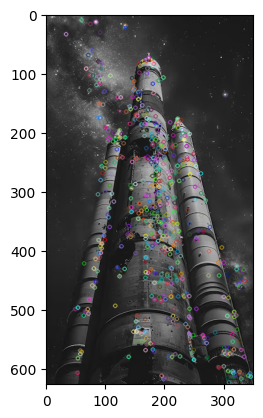

In [3]:
keypoints, des=sift(imgGrey)

In [12]:
len(keypoints)

648

In [9]:
des.shape

(648, 128)

(#keypoints, 128)

This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'

In [3]:
keypoints , des = surf(imgGrey)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


In [2]:

start = time.time()
fv = get_feature_vectors(images_path='isolated_words_per_user',
                     algorithm='sift', 
                     numOfClusters=100)

print('Time taken:', time.time()-start)


Finished extracting BOW descriptors for 8144 images ^_^
Finished clustering BOW descriptors into 100 clusters ^_^
Finished getting BOW histograms for 8144 images ^_^
Time taken: 158.43827629089355


In [3]:

np.save('sift_fv.npy', fv)

In [ ]:

fv[0].shape # 100 cluster


(100,)

In [7]:
fv[0]

array([ 1.,  2.,  1.,  1.,  0.,  1.,  3.,  4.,  1.,  4.,  2.,  0.,  2.,
        2.,  1.,  2., 10.,  0.,  0.,  2.,  1.,  1.,  0.,  3.,  0.,  0.,
        6.,  0.,  4.,  0.,  0.,  0.,  1.,  4.,  0.,  2.,  2.,  0.,  1.,
        2.,  2.,  5.,  0.,  5.,  1.,  2.,  1.,  4.,  4.,  0.,  6.,  1.,
        0.,  1.,  5.,  2.,  0.,  3.,  3.,  3.,  0.,  2.,  1.,  0.,  0.,
        1.,  0.,  7.,  0.,  1., 15.,  2.,  3.,  2.,  1.,  1.,  0.,  4.,
        2.,  0.,  3., 11.,  3.,  1.,  0.,  0.,  1.,  4.,  3.,  5.,  1.,
        4.,  2.,  5.,  0.,  5.,  0.,  3.,  0.,  0.])